In [12]:
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
import os

DATA_DIR = os.path.join("..", "data")

sns.set()

In [3]:
games_df = pd.read_csv(os.path.join(DATA_DIR, "AllSuperDetailedGames.csv"))
games_df.info()

/var/folders/v8/0hd98b512cn3ms2rz146k7jw0000gn/T/ipykernel_70481/712369024.py:1: DtypeWarning: Columns (505,506,507) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv(os.path.join(DATA_DIR, "AllSuperDetailedGames.csv"))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377608 entries, 0 to 377607
Columns: 513 entries, Unnamed: 0.2 to BaselinePrediction
dtypes: float64(364), int64(142), object(7)
memory usage: 1.4+ GB


In [4]:
# create baseline model that predicts the winner of the game only based on the team with the higher seed
# and if the seed is the same, have it be the winning percentage that determines the winner. We will compare
# our ML models to this one to decide if performance is actually good or not.

# def predict_baseline(row: pd.Series) -> int:
#     cs, opp_cs = row["ChalkSeed"], row["OppChalkSeed"]
#     if cs != opp_cs:
#         return 1 if cs < opp_cs else 0
#     return 1 if row["Win mean reg"] > row["OppWin mean reg"] else 0

# games_df["BaselinePrediction"] = games_df.apply(
#     lambda row: predict_baseline(row),
#     axis=1,
# )

In [5]:
games_df.sample(10, random_state=3)

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  Season  DayNum  TeamID  \
179744        179744        179744      179744    2023      69    3166   
65864          65864         65864       65864    2015     131    1437   
70502          70502         70502       70502    2016     115    1150   
347567        347567        347567      347567    2019      74    3434   
10344          10344         10344       10344    2005      47    1416   
22285          22285         22285       22285    2007      99    1397   
247533        247533        247533      247533    2015      17    1183   
265381        265381        265381      265381    2018      60    1209   
168826        168826        168826      168826    2021      30    3235   
108588        108588        108588      108588    2024      19    1456   

        TeamScore  OppTeamID  OppScore WLoc  ...  OppWin median tourney  \
179744         68       3266        42    H  ...                    1.0   
65864          69       1462        52    N  ...                    0.5   
70502         114       1427       108    H  ...                    NaN   
347567         82       3232        86    A  ...                    NaN   
10344          57       1282        56    A  ...                    1.0   
22285          70       1261        67    H  ...                    0.0   
247533         61       1413        63    A  ...                    NaN   
265381         64       1375        86    H  ...                    1.0   
168826         91       3395        68    A  ...                    0.5   
108588         96       1420        81    H  ...                    NaN   

        OppWin mean tourney  Seed  ConfAbbrev    TeamName  FirstD1Season  \
179744             1.000000   NaN         NaN         NaN            NaN   
65864              0.500000   W01    big_east   Villanova         1985.0   
70502                   NaN   NaN         NaN         NaN            NaN   
347567                  NaN   NaN         NaN         NaN            NaN   
10344              1.000000   Z15       a_sun         UCF         1985.0   
22285              0.333333   X05         sec   Tennessee         1985.0   
247533                  NaN   NaN         NaN         NaN            NaN   
265381             1.000000   Y15    sun_belt  Georgia St         1985.0   
168826             0.500000   NaN         NaN         NaN            NaN   
108588                  NaN   NaN         NaN         NaN            NaN   

        LastD1Season  ChalkSeed  OppChalkSeed  BaselinePrediction  
179744           NaN        NaN           NaN                   0  
65864         2024.0        1.0           3.0                   1  
70502            NaN        NaN          16.0                   0  
347567           NaN        NaN           NaN                   0  
10344         2024.0       15.0           NaN                   0  
22285         2024.0        5.0           6.0                   1  
247533           NaN        NaN          16.0                   0  
265381        2024.0       15.0          10.0                   0  
168826           NaN        NaN           NaN                   0  
108588           NaN        NaN          16.0                   0  

[10 rows x 513 columns]

In [6]:
mens_subset = games_df[games_df["League"] == "M"]
wmns_subset = games_df[games_df["League"] == "W"]

In [7]:
mens_baseline_pred_T = torch.tensor(
    mens_subset["BaselinePrediction"].values,
    dtype=torch.float32,
)

mens_actual_T = torch.tensor(
    mens_subset["Win"].values,
    dtype=torch.float32,
)

wmns_baseline_pred_T = torch.tensor(
    wmns_subset["BaselinePrediction"].values,
    dtype=torch.float32,
)

wmns_actual_T = torch.tensor(
    wmns_subset["Win"].values,
    dtype=torch.float32,
)

Mens base model BCE Score: 0.6727877259254456


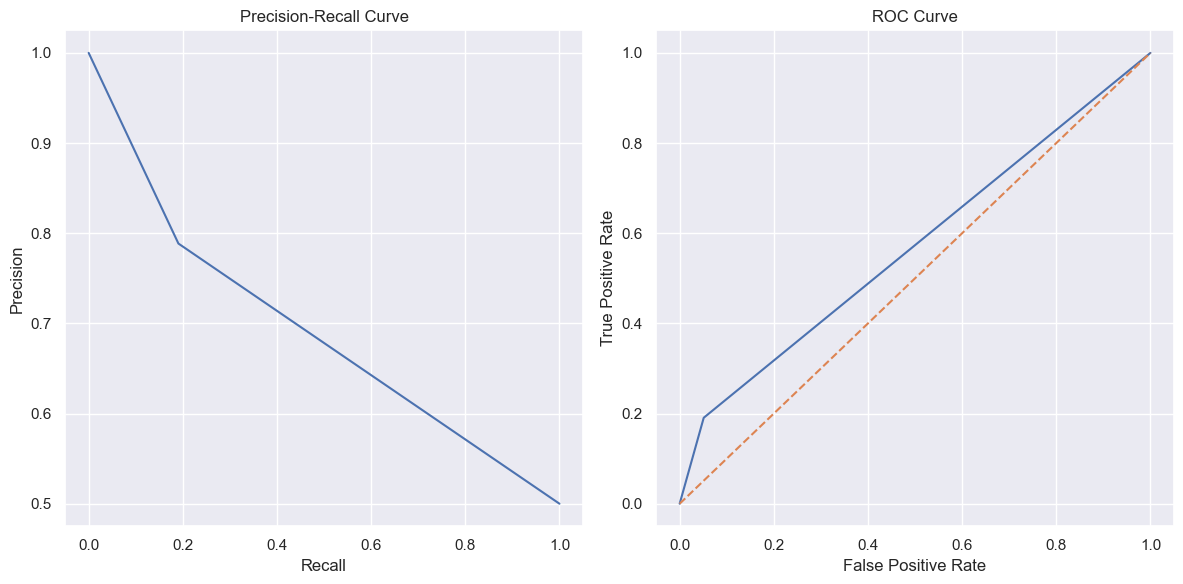

In [13]:
mens_base_bce = nn.BCEWithLogitsLoss()(mens_baseline_pred_T, mens_actual_T).item()
print(f"Mens base model BCE Score: {mens_base_bce}")

m_pred_arr = mens_baseline_pred_T.numpy().flatten()
m_true_arr = mens_actual_T.numpy().flatten()

mfpr, mtpr, mthresholds_roc = roc_curve(m_true_arr, m_pred_arr)
mprecision, mrecall, mthreshold_prob = precision_recall_curve(m_true_arr, m_pred_arr)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mrecall, mprecision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(mfpr, mtpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.tight_layout()
plt.show()

womens base model BCE Score: 0.6931473016738892


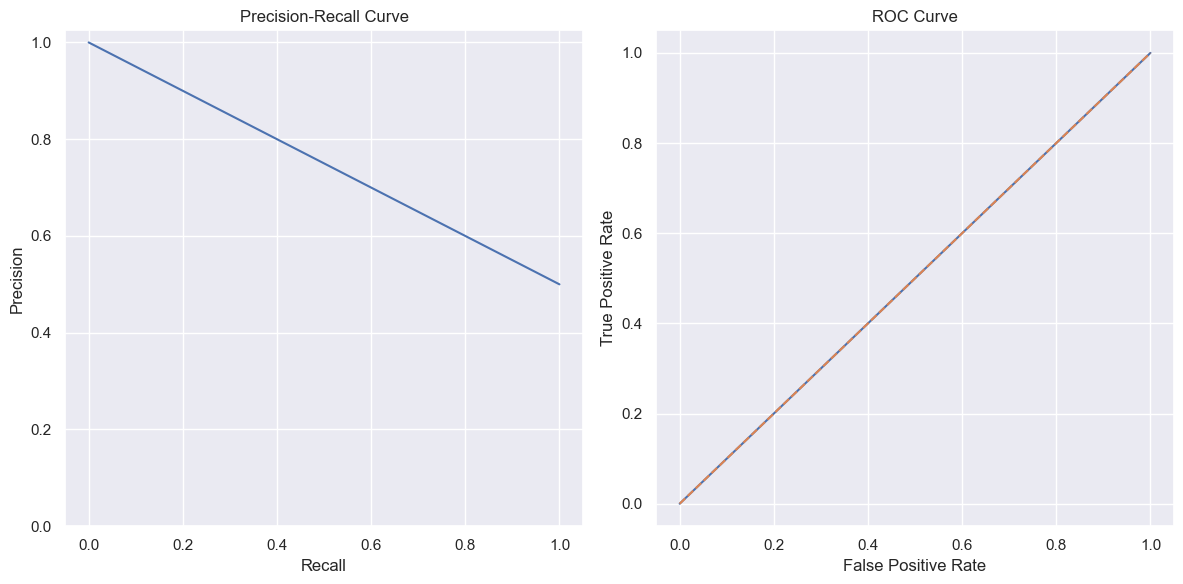

In [14]:
wmns_base_bce = nn.BCEWithLogitsLoss()(wmns_baseline_pred_T, wmns_actual_T).item()
print(f"womens base model BCE Score: {wmns_base_bce}")

w_pred_arr = wmns_baseline_pred_T.numpy().flatten()
w_true_arr = wmns_actual_T.numpy().flatten()

wfpr, wtpr, wthresholds_roc = roc_curve(w_true_arr, w_pred_arr)
wprecision, wrecall, wthreshold_prob = precision_recall_curve(w_true_arr, w_pred_arr)

# Plot Precision-Recall Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(wrecall, wprecision, label="Precision-Recall Curve")
plt.ylim(0)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(wfpr, wtpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.tight_layout()
plt.show()

In [29]:
# save the data with baseline predictions and overwrite the one made in preprocessing
# games_df.to_csv(os.path.join(DATA_DIR, "AllSuperDetailedGames.csv"))